In [1]:
!pip install minatar
!pip install ale-py
!pip install gymnasium

In [2]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
from matplotlib.pyplot import plot


In [3]:
import gymnasium as gym
from gymnasium import spaces
from minatar import Environment


class MinAtarEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, game_name="breakout", render_mode=None):
        super().__init__()
        self.game_name = game_name
        self.render_mode = render_mode

        # Initialize the MinAtar environment
        self.minatar_env = Environment(env_name=self.game_name)

        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=self.minatar_env.state_shape(),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(self.minatar_env.num_actions())

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.minatar_env.reset()
        state = self.minatar_env.state().astype(np.float32)
        return state, {}

    def step(self, action):
        reward, done = self.minatar_env.act(action)
        state = self.minatar_env.state().astype(np.float32)
        return state, reward, done, done, {}

    def render(self):
        arr = (self.minatar_env.state() * np.arange(1,5).reshape(1,1,4)).max(axis=2)
        num_to_char = {
            0: ' ',#background
            1: '\u25AC',#paddle
            2: ' ',#ball trail
            3: '\u25CF',#ball
            4: '\u25FB' #block
        }
        char_grid = np.vectorize(num_to_char.get)(arr)
        final_grid = '\n'.join(''.join(row) for row in char_grid)
        print(final_grid)

    def close(self):
        pass


# Vectorized Environment with Gymnasium's vector API
num_envs = 16
env_fns = [lambda: MinAtarEnv("breakout") for _ in range(num_envs)]
env = gym.vector.SyncVectorEnv(env_fns)

# Example usage
obs, info = env.reset()
actions = env.action_space.sample()
next_obs, rewards, terminated, truncated, infos = env.step(actions)
print("Observations shape:", next_obs.shape)
print("Rewards shape:", rewards.shape)

#vector_env.close()


Observations shape: (16, 10, 10, 4)
Rewards shape: (16,)


In [11]:
device = (
    # "cuda"
    # if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    # else "cpu"
    "cpu"
)
print(f"Using {device} device")

Using cpu device


In [12]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(400,128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,4)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.linear3(x)
        x = nn.Softmax(dim=1)(x)
        return x

class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(400,128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,1)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.linear3(x)
        return x


pi = PolicyNetwork().to(device)
V  = ValueNetwork().to(device)

pi_optimizer = torch.optim.Adam(pi.parameters(), lr=1e-3)
V_optimizer  = torch.optim.Adam(V.parameters(),  lr=1e-3)

pi_old = PolicyNetwork().to(device)
pi_old.load_state_dict(pi.state_dict())

<All keys matched successfully>

In [ ]:
#set hyperparams -- feel free to play with these!!
gamma=0.99
lam=0.95
num_updates=1500
entropy_coef = 0.02  # typical range: 0.01 to 0.1
n_epochs=5
mini_batch_size = 64
T=200 #number of steps to take in each update

total_log=[]
win_log=[]
done_log=np.array([],dtype=bool)
reward_log=np.array([])

new_obs,info=env.reset()
new_obs=torch.tensor(new_obs,dtype=torch.float32,device=device)
new_obs=new_obs.reshape(16,4,10,10)


for e in range(num_updates):
  states = []
  next_states = []
  rewards = []
  actions = []
  dones = []
  values=[]
  log_probs_list = []
  log_probs_old_list = []

  for i in range(T):
    #Collect T steps from each trajectory
    obs=new_obs

    with torch.no_grad():
      probs=pi(obs)
      dist = torch.distributions.Categorical(probs) #check this
      action = probs.multinomial(num_samples=1).squeeze(-1)
      logp_old = dist.log_prob(action)

      log_probs_old_list.append(logp_old)
      states.append(obs)
      actions.append(action)
      values.append(V(obs))

    action_cpu = action.cpu().numpy()
    new_obs,reward, done, truncated, info=env.step(action)
    new_obs=torch.tensor(new_obs,dtype=torch.float32,device=device)
    new_obs=new_obs.reshape(16,4,10,10)
    next_states.append(new_obs)

    #For reward logging:
    if len(reward_log)==0:
      reward_log=np.array([reward])
      done_log=np.array([done])
    else:
      reward_log=np.vstack([reward_log,reward+reward_log[-1,:]*(~done_log[-1,:])])
      done_log=np.vstack([done_log,done])

    reward=torch.tensor(reward,device=device,dtype=torch.float32)
    rewards.append(reward)

    done=torch.tensor(done,device=device,dtype=torch.float32)
    dones.append(done)

  #Compute average reward over last 100 completed episodes:
  if np.sum(done_log)>100:
    avg_rwd=reward_log[done_log][-100:].mean()
  else:
    avg_rwd=0
  total_log.append(avg_rwd)

  #Stack all rewards and dones in buffers
  rewards = torch.stack(rewards, dim=0)       # shape [T, 16]
  dones   = torch.stack(dones,   dim=0)       # shape [T, 16]

  #Add one more value for the last 'new_obs' and then stack all the values together:
  with torch.no_grad():
    values.append(V(new_obs))
  values  = torch.stack(values,  dim=0).squeeze(-1)


  #Compute deltas, gaes, advantages, value targets
  #check this
  deltas = rewards + gamma * values[1:] - values[:-1]
  gaes = torch.zeros_like(deltas)
  gaes[-1] = deltas[-1]
  for t in reversed(range(T-1)):
      gaes[t] = deltas[t] + gamma * lam * gaes[t+1]
  advantages = gaes
  targets = rewards + gamma * values[1:]

  advantages = advantages.view(-1)
  targets    = targets.view(-1)

  #Cat all states, next_states, actions and log_probs in buffers:
  states = torch.cat(states, dim=0)
  next_states = torch.cat(next_states, dim=0)
  actions = torch.cat(actions, dim=0)
  log_probs_old = torch.cat(log_probs_old_list, dim=0)

  N = states.shape[0]  # total number of transitions in the buffer
  for epoch in range(n_epochs):
    # Shuffle the indices
    indices = torch.randperm(N)

    # Create mini-batches
    for start_idx in range(0, N, mini_batch_size):
      end_idx = start_idx + mini_batch_size
      batch_indices = indices[start_idx:end_idx]

      # Extract data for this mini-batch
      s_batch        = states[batch_indices]
      a_batch        = actions[batch_indices]
      logp_old_batch = log_probs_old[batch_indices]
      V_targets      = targets[batch_indices]
      adv_batch      = advantages[batch_indices]

      #Compute pi_loss and v_loss and update pi and v. Use entropy bonus!
      probs_new = pi(s_batch)
      dist = torch.distributions.Categorical(probs_new)
      logp_new = dist.log_prob(a_batch)
      ratio = torch.exp(logp_new - logp_old_batch)
      surr1 = ratio * adv_batch
      surr2 = torch.clamp(ratio, 1 - 0.1, 1 + 0.1) * adv_batch

      # entropy bonus
      entropy = dist.entropy().mean()

      # combine surrogate loss with entropy bonus
      pi_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

      pi_optimizer.zero_grad()
      pi_loss.backward()
      pi_optimizer.step()

      V_loss = nn.MSELoss()(V(s_batch), V_targets)
      V_optimizer.zero_grad()
      V_loss.backward()
      V_optimizer.step()

  pi_old.load_state_dict(pi.state_dict())

  #periodic reporting:
  if e>0 and e%10==0:
    print(f'update: {e}, loss: {pi_loss:.2f}, Average Reward: {avg_rwd}')


update: 10, loss: -0.77, Average Reward: 1.1
update: 20, loss: -0.79, Average Reward: 1.06
update: 30, loss: -0.75, Average Reward: 1.23
update: 40, loss: -0.73, Average Reward: 1.39
update: 50, loss: -0.60, Average Reward: 1.46
update: 60, loss: -0.55, Average Reward: 1.41
update: 70, loss: -0.53, Average Reward: 1.49
update: 80, loss: -0.56, Average Reward: 2.05
update: 90, loss: -0.54, Average Reward: 2.89
update: 100, loss: -0.50, Average Reward: 3.07
update: 110, loss: -0.39, Average Reward: 3.04
update: 120, loss: -0.44, Average Reward: 3.45
update: 130, loss: -0.42, Average Reward: 3.69
update: 140, loss: -0.34, Average Reward: 3.91
update: 150, loss: -0.29, Average Reward: 3.69
update: 160, loss: -0.27, Average Reward: 3.36
update: 170, loss: -0.26, Average Reward: 3.38
update: 180, loss: -0.21, Average Reward: 3.22
update: 190, loss: -0.14, Average Reward: 2.78
update: 200, loss: -0.18, Average Reward: 2.98
update: 210, loss: -0.12, Average Reward: 2.86
update: 220, loss: 0.02

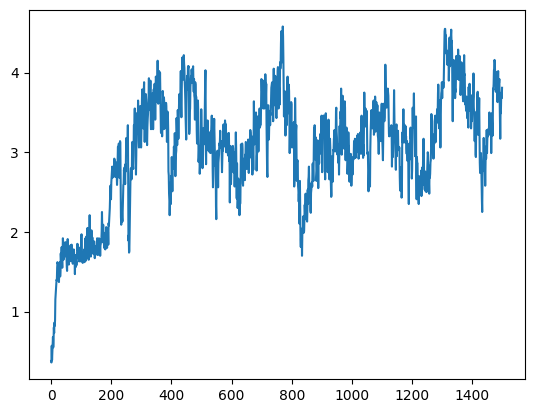

In [ ]:
plot(total_log)

In [ ]:
#create a new single-threaded environment (not vectorized)
eval_env = MinAtarEnv("breakout")

In [ ]:
#Watch it play!!

obs, info = eval_env.reset()
obs=torch.tensor(obs,dtype=torch.float32,device=device)
obs=obs.reshape(1,4,10,10)


done = False
truncated = False

while not done and not truncated:
    eval_env.render()
    with torch.no_grad():
      probs=pi(obs)
      dist = torch.distributions.Categorical(probs)
      action = dist.sample()  # shape [1]
    obs, reward, done, truncated, info = eval_env.step(action)
    obs=torch.tensor(obs,dtype=torch.float32,device=device)
    obs=obs.reshape(1,4,10,10)
    sleep(0.2)
    clear_output(wait=True)

eval_env.render()
eval_env.close()

          
◻◻◻◻◻◻◻◻◻◻
 ◻◻◻◻◻◻◻◻◻
◻ ◻◻◻◻◻◻  
          
          
          
          
     ●    
         ▬
